In [1]:
import warnings 
warnings.filterwarnings('ignore')
import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import sys
sys.path.append('.')
sys.path.append('..')
import yaml 
import argparse
import traceback
import time
import torch

from model.models import STSSL
from model.trainer import Trainer
from lib.dataloader import get_dataloader
from lib.utils import (
    init_seed,
    get_model_params,
    load_graph, 
)

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument('--config_filename', default=r'D:\omer\ST-SSL_SIMPLE2\configs\NYCTaxi.yaml', 
                type=str, help='the configuration to use')
args, unknown = parser.parse_known_args()
print(f'Starting experiment with configurations in {args.config_filename}...')
time.sleep(3)
configs = yaml.load(
    open(args.config_filename), 
    Loader=yaml.FullLoader
)
configs['graph_init'] = "8_neighbours"

configs['self_attention_flag'] = True
configs['cross_attention_flag'] = False
configs['feedforward_flag'] = False
configs['layer_norm_flag'] = False
configs['additional_sa_flag'] = False
configs['learnable_flag'] = False
configs['pos_emb_flag'] = False
configs['rank'] = False
configs['add_8'] = True
configs['add_eye'] = False
configs['add_x_encoder'] = False
configs['freeze_encoder'] = True
configs['cheb_order'] = 3
configs['experimentName'] = "test"
configs['S_Loss'] = False
configs['T_Loss'] = False
configs['seed'] = 2
configs['comment'] = "noComment"
configs['ipe'] = 1000
configs['loss'] = "mse"
configs['threshold_adj_mx'] = False
configs['affinity_conv'] = False
args = argparse.Namespace(**configs)


Starting experiment with configurations in D:\omer\ST-SSL_SIMPLE2\configs\NYCTaxi.yaml...


In [3]:
print(args.seed)

2


In [4]:
init_seed(args.seed)
if not torch.cuda.is_available():
    args.device = 'cuda'

## load dataset
dataloader = get_dataloader(
    data_dir=args.data_dir, 
    dataset=args.dataset, 
    batch_size=args.batch_size, 
    test_batch_size=args.test_batch_size,
    scalar_type='Standard'
)
graph = load_graph(args.graph_file, device=args.device)
args.num_nodes = len(graph)

## init model and set optimizer
model = STSSL(args).to(args.device)

args.best_path = r'D:\omer\ST-SSL_simple2\experiments\NYCTaxi\pred__seed=1\20240708-120539\mse loss, sa\best_model.pth'
state_dict = torch.load(
                args.best_path,
                map_location=torch.device(args.device)
            )
msg = model.load_state_dict(state_dict['model'])
print("Load saved model msg: ", msg)

model_parameters = get_model_params([model])
optimizer = torch.optim.Adam(
    params=model_parameters, 
    lr=args.lr_init, 
    eps=1.0e-8, 
    weight_decay=0, 
    amsgrad=False
)



!!Scaling is NOT off!!


data['x_train'].shape:  (1912, 35, 200, 2) (1912, 1, 200, 2) 

!!train shuffle is True!!


in else
in else
Load saved model msg:  <All keys matched successfully>


In [5]:
## start training
trainer = Trainer(
    model=model, 
    optimizer=optimizer, 
    dataloader=dataloader,
    graph=graph, 
    args=args
)

2024-07-09 12:31:26: 
Model has 1.141644 M trainable parameters
2024-07-09 12:31:26: Experiment log path in: D:\omer\ST-SSL_simple2\experiments\NYCTaxi\test\20240709-123126\noComment
2024-07-09 12:31:26: Experiment configs are: Namespace(S_Loss=False, T_Loss=False, add_8=True, add_eye=False, add_x_encoder=False, additional_sa_flag=False, affinity_conv=False, batch_size=32, best_path='D:\\omer\\ST-SSL_simple2\\experiments\\NYCTaxi\\pred__seed=1\\20240708-120539\\mse loss, sa\\best_model.pth', cheb_order=3, col=10, comment='noComment', cross_attention_flag=False, d_input=2, d_model=64, d_output=2, data_dir='data', dataset='NYCTaxi', debug=False, device='cuda', dropout=0.1, early_stop=True, early_stop_patience=35, epochs=1000, experimentName='test', feedforward_flag=False, freeze_encoder=True, grad_norm=True, graph_file='data/NYCTaxi/adj_mx.npz', graph_init='8_neighbours', input_length=35, ipe=1000, layer_norm_flag=False, learnable_flag=False, log_dir='D:\\omer\\ST-SSL_simple2\\experiment

dummy forward pass done.
Creat Log File in:  D:\omer\ST-SSL_simple2\experiments\NYCTaxi\test\20240709-123126\noComment\run.log


In [66]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lib.metrics import test_metrics


def test_nodes(model, dataloader, scaler, graph, logger, args):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            repr1, repr2 = model(data, graph)                
            pred_output = model.predict(repr1, repr2)

            y_true.append(target)
            y_pred.append(pred_output)

    y_true = torch.cat(y_true, dim=0).cpu().numpy()
    y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
    # y_true = scaler.inverse_transform(torch.cat(y_true, dim=0)).cpu().numpy()
    # y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0)).cpu().numpy()
    t = scaler.transform(5)
    print(f't: {t}')
    mask = np.where(y_true > (t), True, False)
    # true = true[mask]
    # pred = pred[mask]
    test_results = []
    # inflow
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
    logger.info("inflow, MAE: {:.2f}, inflow MAPE: {:.4f}%".format(mae, mape*100))
    # test_results.append([mae, mape])

    # outflow 
    mae, mape = test_metrics(y_pred[..., 1], y_true[..., 1])
    logger.info("OUTFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
    # test_results.append([mae, mape]) 

    y_true_masked = np.where(mask, y_true, np.nan)
    y_pred_masked = np.where(mask, y_pred, np.nan)
    
    # y_true.shape: [546, 1, 200, 2]

    # Calculate MAE for each node for the inflow (index 0 of last dimension)
    node_maes = np.nanmean(np.abs(y_pred_masked[..., 0] - y_true_masked[..., 0]), axis=(0, 1))
    total_mae = np.nansum(node_maes)  # Total MAE across all nodes

    # Calculate contribution of each node to the total MAE
    contributions = (node_maes / total_mae) * 100  # Convert to percentage
    contributions = contributions[50:100]
    # Plotting the contribution for each node
    plt.figure(figsize=(20, 8))  # Larger figure size
    plt.bar(range(len(contributions)), contributions, tick_label=range(len(contributions)))
    plt.title('Contribution of each node to Total MAE (inflow)')
    plt.xlabel('Node Index')
    plt.ylabel('Percentage Contribution to Total MAE (%)')
    plt.xticks(rotation=90)  # Rotate labels to avoid overlap
    plt.grid(True)  # Optional: add grid for better readability
    plt.show()
    return 0


2024-07-09 13:10:57: inflow, MAE: 0.39, inflow MAPE: 6.3587%
2024-07-09 13:10:57: OUTFLOW, MAE: 0.38, MAPE: 6.0721%


t: -0.32245962163185815


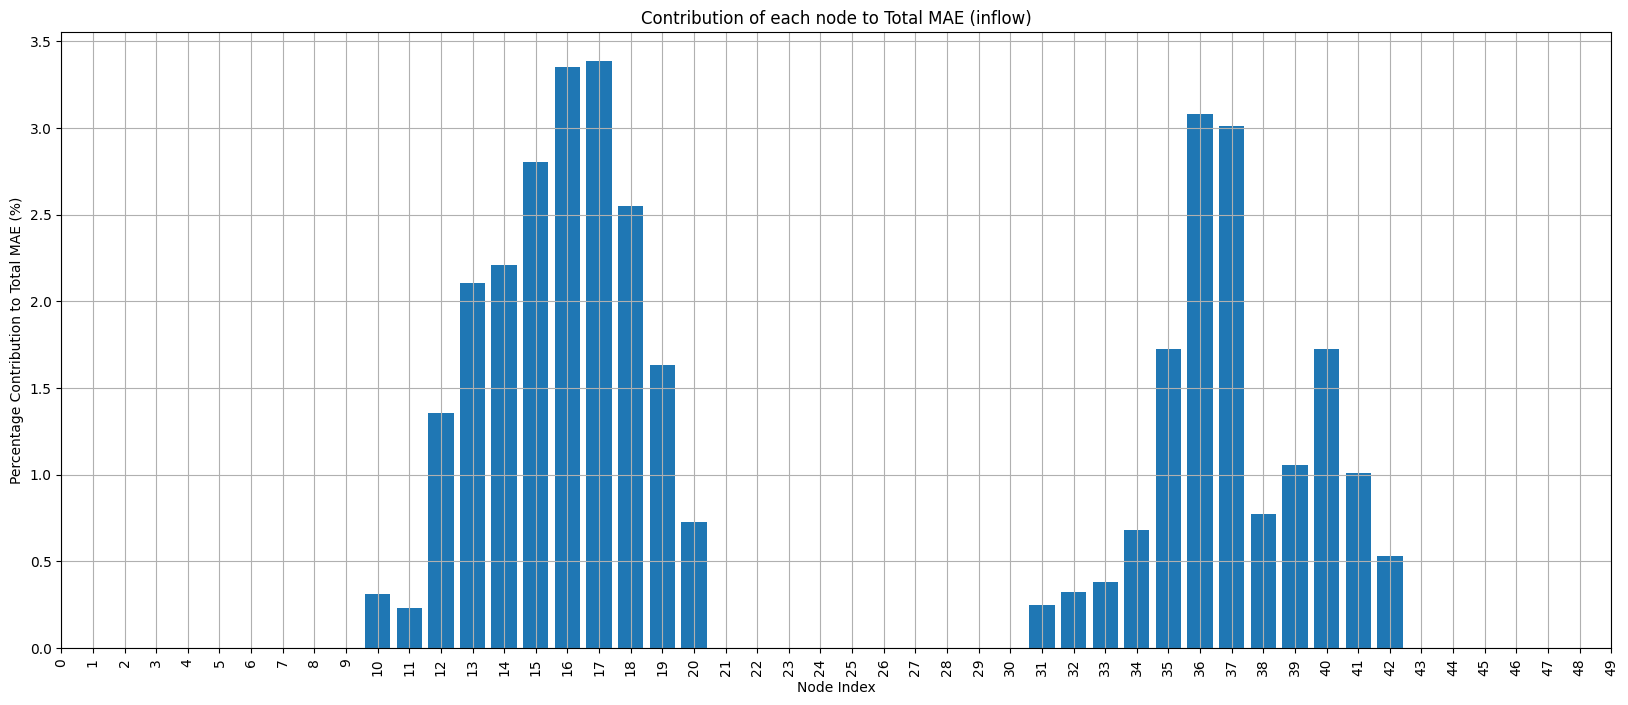

0

: 

In [67]:
test_nodes(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

In [53]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lib.metrics import test_metrics


def test(model, dataloader, scaler, graph, logger, args):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            repr1, repr2 = model(data, graph)                
            pred_output = model.predict(repr1, repr2)

            y_true.append(target)
            y_pred.append(pred_output)

    # y_true = torch.cat(y_true, dim=0).cpu().numpy()
    # y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
    y_true = scaler.inverse_transform(torch.cat(y_true, dim=0)).cpu().numpy()
    y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0)).cpu().numpy()
    mask = np.where(y_true > (5), True, False)
    # true = true[mask]
    # pred = pred[mask]
    test_results = []
    # inflow
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
    logger.info("test, MAE: {:.2f}, test MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape])
    
    print("y_true.shape: ", y_true.shape, "y_pred.shape: ", y_pred.shape)

    # Plotting
    plt.figure(figsize=(10, 5))
    
    ## to plot all regions 
    # plt.plot(y_true[..., 0].flatten()[3000:4000], label='True Values')
    # plt.plot(y_pred[..., 0].flatten()[3000:4000], label='Predictions')
    ## to plot summed up regions
    # plt.plot(np.sum(y_true[:, :, :, :], axis=2).flatten()
    #         , label='True Values')
    # plt.plot(np.sum(y_pred[:, :, :, :], axis=2).flatten(), label='Predictions')
    mask = y_true > 5

    # Apply the mask to y_true and y_pred to filter values
    masked_y_true = np.where(mask, y_true, np.nan)  # Replace unmasked values with NaN
    masked_y_pred = np.where(mask, y_pred, np.nan)  # Same for y_pred

    # Sum and flatten the masked values for plotting
    # Using np.nansum to ignore NaN values in summation
    summed_masked_y_true = np.nansum(masked_y_true, axis=2).flatten()
    summed_masked_y_pred = np.nansum(masked_y_pred, axis=2).flatten()
    plt.plot(summed_masked_y_true, label='True Values (Masked)')
    plt.plot(summed_masked_y_pred, label='Predictions (Masked)')
    plt.title("Comparison of True and Predicted Values")
    plt.xlabel("Sample")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

    # outflow 
    mae, mape = test_metrics(y_pred[..., 1], y_true[..., 1])
    logger.info("OUTFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
    # test_results.append([mae, mape]) 

    return np.stack(test_results, axis=0)


In [22]:
def test(model, dataloader, scaler, graph, logger, args):
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            repr1, repr2 = model(data, graph)                
            pred_output = model.predict(repr1, repr2)

            y_true.append(target)
            y_pred.append(pred_output)
    y_true = scaler.inverse_transform(torch.cat(y_true, dim=0))
    y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0))

    test_results = []
    # inflow
    # print("y_pred.shape: ", y_pred.shape, "y_true.shape: ", y_true.shape)
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
    logger.info("INFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape])
    # outflow 
    mae, mape = test_metrics(y_pred[..., 1], y_true[..., 1])
    logger.info("OUTFLOW, MAE: {:.2f}, MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape]) 

    return np.stack(test_results, axis=0)

2024-07-08 15:03:39: test, MAE: 12.11, test MAPE: 18.8069%


y_true.shape:  (546, 1, 200, 2) y_pred.shape:  (546, 1, 200, 2)


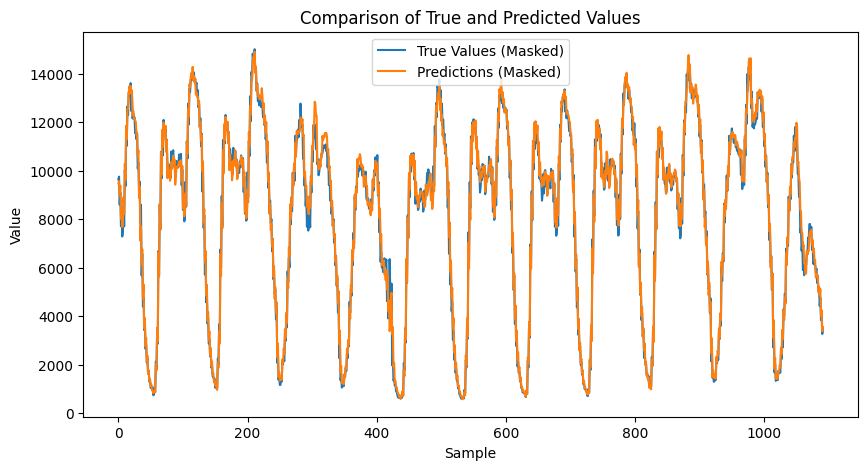

2024-07-08 15:03:40: OUTFLOW, MAE: 9.92, MAPE: 18.8825%


array([[12.106983  ,  0.18806876]], dtype=float32)

In [28]:
test(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

2024-07-08 15:04:40: test, MAE: 11.94, test MAPE: 18.6044%


y_true.shape:  (546, 1, 200, 2) y_pred.shape:  (546, 1, 200, 2)


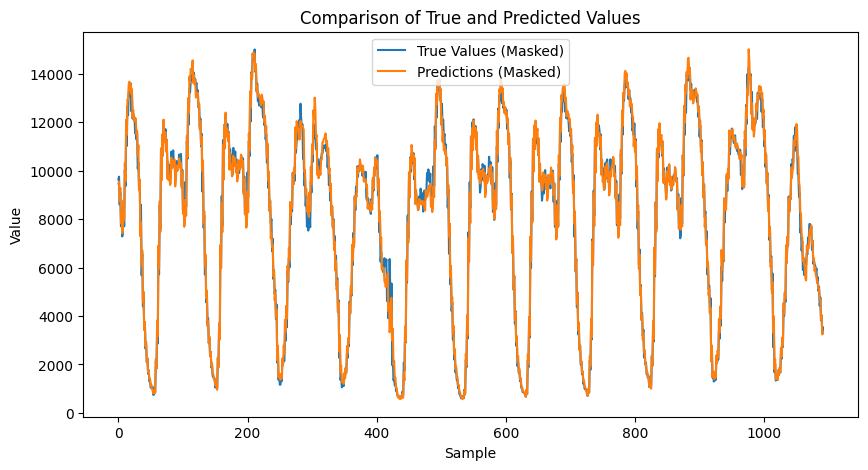

2024-07-08 15:04:40: OUTFLOW, MAE: 9.81, MAPE: 16.8317%


array([[11.936283 ,  0.1860435]], dtype=float32)

In [32]:
test(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

In [24]:
state_dict = torch.load(
    args.best_path,
    map_location=torch.device(args.device)
)
model.load_state_dict(state_dict['model'])
print("Load saved model")
results = trainer.test(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)

Load saved model


2024-07-08 15:03:18: INFLOW, MAE: 12.11, MAPE: 18.8069%
2024-07-08 15:03:18: OUTFLOW, MAE: 9.92, MAPE: 18.8825%


In [8]:

def test_rolling(model, dataloader, scaler, graph, logger, args):
    model.eval()
    y_pred = []
    y_true = []
    prediction_buffer = None  # Buffer to hold predictions for future time steps

    # torch.Size([batch_size=1, time_steps=19, no.ofnodes=285, features=1]) data shape
    # torch.Size([1, 1, 285, 1]) pred_output shape
    # print("len(dataloader): ", len(dataloader))
    with torch.no_grad():
        for idx, (data, target) in enumerate(dataloader):
            # print(f"idx: {idx}, data.shape: {data.shape}, target.shape: {target.shape}")
            # Update data with predictions from buffer
            if prediction_buffer is not None:
                for t in range(len(prediction_buffer)):
                    if t <= data.shape[1]:  # Ensure the time step exists in the data
                        # print("data.shape: ", data.shape, "data[:, t, :, :].shape: ", data[:, t, :, :].shape, "prediction_buffer[t].shape: ", prediction_buffer[t].shape)
                        # print(f"for data at index {idx} replacing data[:, {t}, :, :] with prediction_buffer[{t}]")
                        data[:, t, :, :] = prediction_buffer[t].squeeze(1)

            repr1, repr2 = model(data, graph)
            pred_output = model.predict(repr1, repr2)

            y_true.append(target)
            y_pred.append(pred_output)

            # Update the prediction buffer
            if prediction_buffer is None:
                prediction_buffer = [pred_output]
            else:
                prediction_buffer.insert(0, pred_output)  ## insert at 0th index
                prediction_buffer = prediction_buffer[:data.shape[1]]  # Keep buffer size same as the number of time steps

    y_true = torch.cat(y_true, dim=0).cpu().numpy()
    y_pred = torch.cat(y_pred, dim=0).cpu().numpy()
    # y_true = scaler.inverse_transform(torch.cat(y_true, dim=0)).cpu().numpy()
    # y_pred = scaler.inverse_transform(torch.cat(y_pred, dim=0)).cpu().numpy()

    test_results = []

    print("y_true.shape: ", y_true.shape, "y_pred.shape: ", y_pred.shape)

    # Plotting
    plt.figure(figsize=(10, 5))
    
    ## to plot all regions 
    # plt.plot(y_true[..., 0].flatten()[3000:3100], label='True Values')
    # plt.plot(y_pred[..., 0].flatten()[3000:3100], label='Predictions')
    ## to plot summed up regions
    plt.plot(np.sum(y_true[:, :, :, :], axis=2).flatten(), label='True Values')
    plt.plot(np.sum(y_pred[:, :, :, :], axis=2).flatten(), label='Predictions')
    
    plt.title("Comparison of True and Predicted Values")
    plt.xlabel("Sample")
    plt.ylabel("Value")
    plt.legend()
    plt.show()
    
    # inflow
    mae, mape = test_metrics(y_pred[..., 0], y_true[..., 0])
    logger.info("rolling, MAE: {:.2f}, rolling MAPE: {:.4f}%".format(mae, mape*100))
    test_results.append([mae, mape])

    return np.stack(test_results, axis=0)

y_true.shape:  (864, 1, 128, 2) y_pred.shape:  (864, 1, 128, 2)


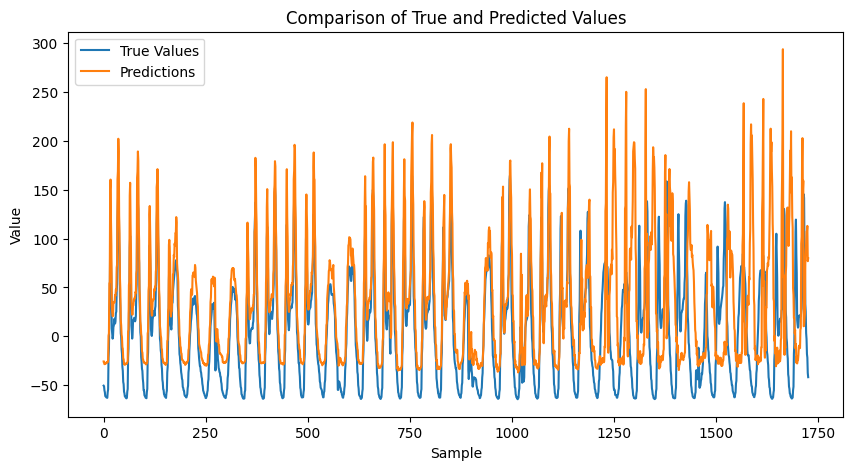

2024-02-07 02:01:54: rolling, MAE: 0.50, rolling MAPE: 129.6789%


array([[0.49504986, 1.296789  ]], dtype=float32)

In [9]:
test_rolling(model, dataloader['test'], dataloader['scaler'],
            graph, trainer.logger, trainer.args)